In [10]:
import os, json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support


In [11]:
def load_labels(model_dir):
    with open(os.path.join(model_dir, "label_map.json"), "r", encoding="utf-8") as f:
        m = json.load(f)
    id2label = {int(k): v for k, v in m["id2label"].items()}
    return id2label

def try_load_keras(model_dir):
    return tf.keras.models.load_model(model_dir, compile=False)

def try_load_savedmodel(model_dir):
    sm = tf.saved_model.load(model_dir)
    infer = sm.signatures.get("serving_default", None)
    if infer is None:
        raise ValueError("No 'serving_default' signature in SavedModel.")
    return infer


In [12]:
def load_labels(model_dir):
    with open(os.path.join(model_dir, "label_map.json"), "r", encoding="utf-8") as f:
        m = json.load(f)
    id2label = {int(k): v for k, v in m["id2label"].items()}
    return id2label

def try_load_keras(model_dir):
    return tf.keras.models.load_model(model_dir, compile=False)

def try_load_savedmodel(model_dir):
    sm = tf.saved_model.load(model_dir)
    infer = sm.signatures.get("serving_default", None)
    if infer is None:
        raise ValueError("No 'serving_default' signature in SavedModel.")
    return infer


In [13]:
def predict_texts(model_or_fn, id2label, texts, batch_size=32, is_keras=True):
    if is_keras:
        ds = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)
        probs = model_or_fn.predict(ds)
    else:
        try:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string)[:, None])
        except Exception:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string))
        probs = next(iter(out.values())).numpy()

    idx = probs.argmax(axis=1)
    conf = probs[np.arange(len(texts)), idx]
    labels = [id2label[int(i)] for i in idx]
    return labels, conf, probs


In [14]:
def predict_texts(model_or_fn, id2label, texts, batch_size=32, is_keras=True):
    if is_keras:
        ds = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)
        probs = model_or_fn.predict(ds)
    else:
        try:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string)[:, None])
        except Exception:
            out = model_or_fn(text=tf.constant(texts, dtype=tf.string))
        probs = next(iter(out.values())).numpy()

    idx = probs.argmax(axis=1)
    conf = probs[np.arange(len(texts)), idx]
    labels = [id2label[int(i)] for i in idx]
    return labels, conf, probs


In [15]:
# ==== CẤU HÌNH MODEL_DIR & CÂU CẦN TEST ====
MODEL_DIR = "/home/dat/llm_ws/bilstm/bilstm_vn_sentiment_5cls"  # đổi lại path model của bạn
text = "Sản phẩm dùng rất tốt, giao hàng nhanh."

# ==== LOAD LABEL MAP ====
id2label = load_labels(MODEL_DIR)
print("id2label:", id2label)

# ==== THỬ LOAD KERAS, NẾU FAIL THÌ DÙNG SAVEDMODEL ====
try:
    model_or_fn = try_load_keras(MODEL_DIR)
    is_keras = True
    print("Loaded Keras model.")
except Exception as e:
    print("Không load được Keras, thử SavedModel. Lỗi:", e)
    model_or_fn = try_load_savedmodel(MODEL_DIR)
    is_keras = False
    print("Loaded SavedModel (tf.saved_model.load).")

# ==== PREDICT 1 CÂU ====
pred_labels, confs, probs = predict_texts(
    model_or_fn,
    id2label,
    [text],        # list 1 phần tử
    batch_size=1,
    is_keras=is_keras
)

print("Text:", text)
print("Predicted label:", pred_labels[0])
print("Confidence:", float(confs[0]))
print("Raw probs:", probs[0])


id2label: {0: 'very_negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'very_positive'}


2025-11-16 00:55:42.877826: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:42.881351: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:42.921987: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:42.927567: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:42.934408: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_sh

Loaded Keras model.
1/1 [==============================] - 1s 1s/step
Text: Sản phẩm dùng rất tốt, giao hàng nhanh.
Predicted label: very_positive
Confidence: 0.5827222466468811
Raw probs: [3.5503868e-04 8.7209791e-04 7.3673315e-03 4.0868327e-01 5.8272225e-01]


In [16]:
# đường dẫn model & file CSV
model_dir = "bilstm_vn_sentiment_5cls"
csv_file = "/home/dat/llm_ws/data/test/test.csv"   # file CSV có cột 'text' và 'label'

# load label map
id2label = load_labels(model_dir)

# load model
is_keras = True
try:
    model_or_fn = try_load_keras(model_dir)
except:
    model_or_fn = try_load_savedmodel(model_dir)
    is_keras = False

# đọc dữ liệu
df = pd.read_csv(csv_file)
texts = df["text"].astype(str).tolist()
true_labels = df["label"].tolist()

# dự đoán
pred_labels, conf, probs = predict_texts(model_or_fn, id2label, texts, is_keras=is_keras)


2025-11-16 00:55:46.470406: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:46.473884: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:46.515389: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:46.520963: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-16 00:55:46.527807: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_sh

17/17 [==============================] - 1s 16ms/step


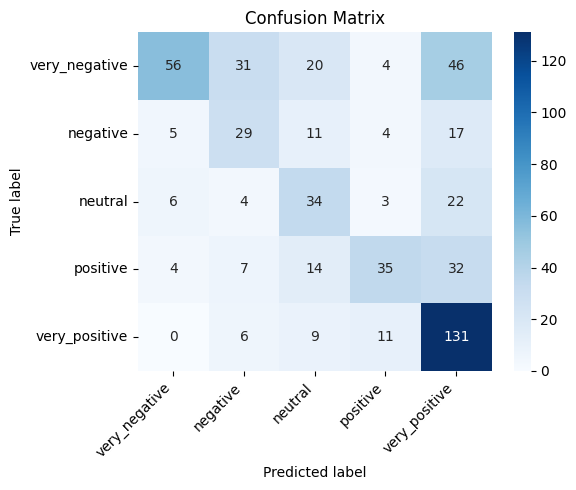

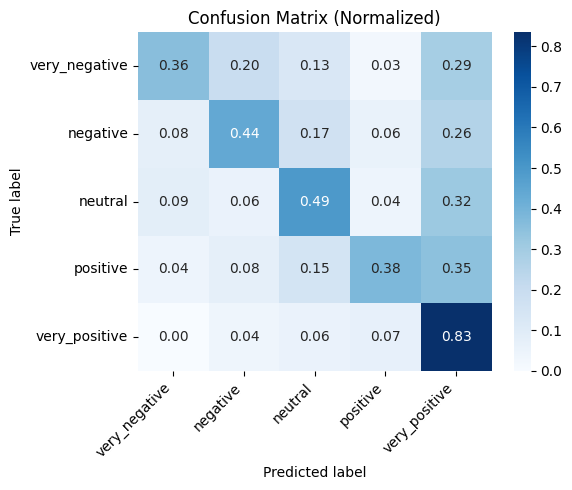

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

labels = list(id2label.values())

# ===== Confusion matrix (đếm) =====
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")   # << xoay chữ xéo sang trái
plt.tight_layout()
plt.show()

# ===== Confusion matrix chuẩn hóa theo hàng =====
cm_norm = cm.astype("float")
row_sums = cm_norm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_norm, row_sums, out=np.zeros_like(cm_norm), where=row_sums != 0)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Normalized)")
plt.xticks(rotation=45, ha="right")   # << xoay chữ xéo sang trái
plt.tight_layout()
plt.show()


In [9]:
print("BiLSTM")
print("Classification Report:")
print(classification_report(true_labels, pred_labels, digits=3))

accuracy = accuracy_score(true_labels, pred_labels)
prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")


BiLSTM
Classification Report:
               precision    recall  f1-score   support

          nan      0.000     0.000     0.000         1
     negative      0.385     0.455     0.417        66
      neutral      0.360     0.449     0.400        69
     positive      0.446     0.446     0.446        92
very_negative      0.743     0.478     0.581       157
very_positive      0.541     0.637     0.585       157

     accuracy                          0.511       542
    macro avg      0.412     0.411     0.405       542
 weighted avg      0.540     0.511     0.515       542

Accuracy: 0.511
Precision: 0.540
Recall: 0.511
F1-score: 0.515


/home/dat/llm_ws/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dat/llm_ws/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dat/llm_ws/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dat/llm_ws/.venv/lib/pyth

In [11]:
import time
import tensorflow as tf
import numpy as np
import json
import os
import tensorflow as tf

# ===============================================
# CONFIG
# ===============================================
MODEL_DIR = "/home/dat/llm_ws/bilstm/bilstm_vn_sentiment_5cls"
TEST_TEXT = "Sản phẩm dùng khá ổn, chất lượng tạm chấp nhận được."
N = 1000  # số lần lặp để đo thời gian
# ===============================================

DEFAULT_LABELS = ["negative", "neutral", "positive"]

def load_savedmodel(model_dir):
    obj = tf.saved_model.load(model_dir)
    infer = obj.signatures.get("serving_default")
    if infer is None:
        raise RuntimeError("No 'serving_default' signature found.")
    return infer

def load_label_map(model_dir):
    lm_path = os.path.join(model_dir, "label_map.json")
    if os.path.exists(lm_path):
        with open(lm_path, "r", encoding="utf-8") as f:
            lm = json.load(f)
        id2label = {int(k): v for k, v in lm["id2label"].items()}
    else:
        id2label = {i: lab for i, lab in enumerate(DEFAULT_LABELS)}
    return id2label

def predict_one_tf(infer, id2label, text):
    outs = infer(text=tf.constant([[text]], dtype=tf.string))
    y = list(outs.values())[0].numpy()[0]
    pred_id = int(np.argmax(y))
    return id2label[pred_id], float(y[pred_id]), y


# === Load model ===
id2label = load_label_map(MODEL_DIR)
infer = load_savedmodel(MODEL_DIR)

# === Warm-up ===
_ = predict_one_tf(infer, id2label, TEST_TEXT)

# === Inference 1000 lần ===
t0 = time.time()
for _ in range(N):
    _ = predict_one_tf(infer, id2label, TEST_TEXT)
t1 = time.time()

total_time = t1 - t0
avg_time = total_time / N

# === Chạy một lần để in kết quả cho đẹp ===
lbl, conf, probs = predict_one_tf(infer, id2label, TEST_TEXT)
ranked = sorted([(id2label[i], float(p)) for i, p in enumerate(probs)],
                key=lambda x: x[1], reverse=True)

print("===== TensorFlow SavedModel Inference =====")
print("Model dir    :", MODEL_DIR)
print("Test text    :", TEST_TEXT)
print("Prediction   :", lbl)
print("Confidence   :", f"{conf:.4f}\n")

print(f"Số lần lặp     : {N}")
print(f"Tổng thời gian : {total_time:.4f} s")
print(f"Thời gian 1 câu: {avg_time*1000:.2f} ms")

print("\nProbabilities:")
for lab, p in ranked:
    print(f" - {lab:12s}: {p:.4f}")



2025-11-14 22:54:11.920272: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 22:54:12.470772: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 22:54:12.531160: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 22:54:12.535692: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2025-11-14 22:54:12.582098: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'cond/while' has 14 outputs but the _output_sh

===== TensorFlow SavedModel Inference =====
Model dir    : /home/dat/llm_ws/bilstm/bilstm_vn_sentiment_5cls
Test text    : Sản phẩm dùng khá ổn, chất lượng tạm chấp nhận được.
Prediction   : neutral
Confidence   : 0.9859

Số lần lặp     : 1000
Tổng thời gian : 2.9929 s
Thời gian 1 câu: 2.99 ms

Probabilities:
 - neutral     : 0.9859
 - positive    : 0.0140
 - very_positive: 0.0000
 - very_negative: 0.0000
 - negative    : 0.0000
